# Question 3

1. Given a start-point, a goal point, and two obstacles (defined in the provided code), implement the artificial potential field method to plan a collision-free trajectory from the starting point to the target point, while avoiding the two obstacles.
2. Visualize the planned trajectory, clearly showing the start point, target point, obstacles, and the path generated by your planner.

Notes:
- We have F(att) which is the force towards a goal, and F(rep), which is the force away from an object
- Adding these forces together we get Q(u) for a given [x,y] u
- Working out Q(u) and moving accordingly lets us move sufficiently away from obstacles while still moving towards the goal
- This is good because:
    - We don't need any global knowledge
    - We only need to know about where the GOAL and LOCAL OBSTACLES are
- There are some traps that can be gotten into if F(att) and F(repp) cancel each other out - in this case global planning may be required
- We can use GRADIENT DESCENT to find the q minimising U(q)
- IOW, from a given point, where can we go where we would get the minimum U(q)
- Remember that force is the negative of the gradient of potential

Plan:
 - Start at Position A
 - Define a distance away from Position A to check
 - Look at all positions around Position A within this defined distance and pick the position with the lowest U(q) value
 - Update current_pos to Position Q and repeat

In [163]:
# import necessary python packages
import torch
import matplotlib.pyplot as plt

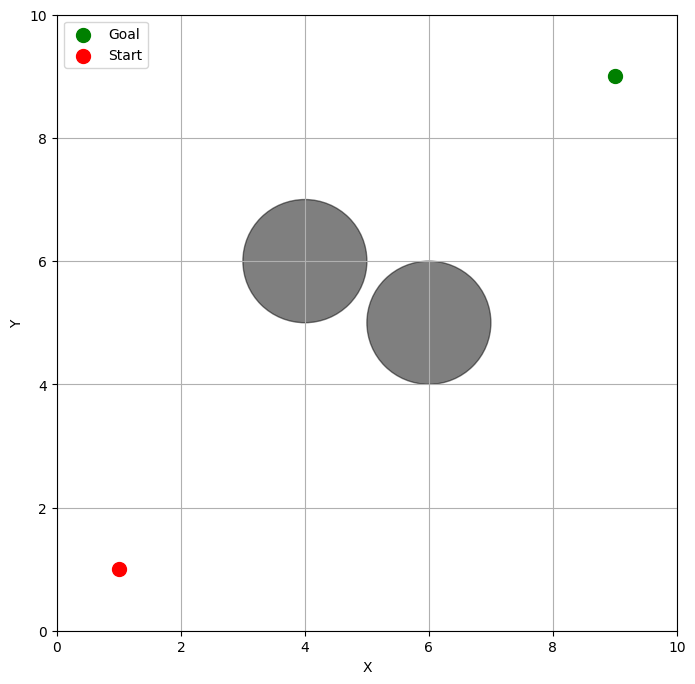

In [164]:
# Parameters for the environment
Goal = torch.tensor([9.0, 9.0], dtype=torch.float32)  # goal position
Start = torch.tensor([1.0, 1.0], dtype=torch.float32)  # start position

Obstacles = torch.tensor([[4.0, 6.0], [6.0, 5.0]], dtype=torch.float32)  # obstacle positions
Obstacle_radius = 1  # radius of the circular obstacles
Threshold = 4 # Threshold (i.e., rho_0), typically larger than Obstacle_radius
Constant_Parameter_K = 1

# Plotting the environment
plt.figure(figsize=(8, 8))
plt.scatter(Goal[0], Goal[1], color="green", label="Goal", s=100)
plt.scatter(Start[0], Start[1], color="red", label="Start", s=100)
for obs in Obstacles.numpy():
    circle = plt.Circle((obs[0], obs[1]), Obstacle_radius, color="black", alpha=0.5)
    plt.gca().add_artist(circle)
# Create a grid environment
grid_size = 10  # size of the grid
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [165]:
# parameters for attractive force and repulsive force
k_att = 1.0  # attractive constant
k_rep = 100.0  # repulsive constant

# Attractive potential field (towards goal)
def attractive_potential(pos, goal):
    return 0.5 * k_att * torch.norm(pos - goal) ** 2

# Repulsive potential field (away from obstacles)
def repulsive_potential(pos, obstacles, threshold):
    rep_total = 0
    for obs in obstacles:
        dist = torch.norm(pos - obs)
        if dist <= threshold:
            potential = 0.5 * k_rep * (1.0 / dist - 1.0 / threshold) ** 2
        else:
            potential = torch.tensor(0.0)  # zero if distance > threshold (means the robot is far from the obstacle)
        rep_total += potential
    return rep_total

# Total potential is attr + potential
def total_potential(pos, goal, obstacles, threshold):
    attr = attractive_potential(pos, goal)
    rep = repulsive_potential(pos, obstacles, threshold)
    return attr + rep

def find_gradient(pos, goal, obstacles, threshold, step_size):
    # future_pos = torch.tensor([pos[0] + step_size, pos[1] + step_size])
    future_pos_x = torch.tensor([pos[0] + step_size, pos[1]])
    future_pos_y = torch.tensor([pos[0], pos[1] + step_size])
    gradient = torch.tensor([0.0, 0.0])
    # gradient = (total_potential(future_pos, goal, obstacles, threshold) - total_potential(pos, goal, obstacles, threshold)) / step_size
    gradient[0] = (total_potential(future_pos_x, goal, obstacles, threshold) - total_potential(pos, goal, obstacles, threshold)) / step_size
    gradient[1] = (total_potential(future_pos_y, goal, obstacles, threshold) - total_potential(pos, goal, obstacles, threshold)) / step_size
    return gradient
    

def attractive_force(pos, goal):
    return -k_att * (pos - goal)

def repulsive_force(pos, obstacles, threshold):
    force_total = torch.tensor([0.0, 0.0])
    for obs in obstacles:
        dist = torch.norm(pos - obs)
        if dist <= threshold:
            force = k_rep * ((1/dist) - (1/threshold)) * (1/(dist**2)) * ((pos-obs)/dist)
        else:
            force = torch.tensor(0.0)
        force_total += force
    return force_total

def total_force(pos, goal, obstacles, threshold):
    attr = attractive_force(pos, goal)
    rep = repulsive_force(pos, obstacles, threshold)
    # print(pos, attr, rep)
    return attr + rep

In [176]:
# TODO: implement your code here, where you can use the above two provided functions

step_size = 0.0001
current_pos = Start.clone()
current_grad = find_gradient(current_pos, Goal, Obstacles, Threshold, step_size)
trajectory = [current_pos.clone()]

while (-current_grad[0] > 0.01 or -current_grad[1] > 0.01):
    alpha = 0.01
    current_grad = find_gradient(current_pos, Goal, Obstacles, Threshold, step_size)
    current_pos[0] = current_pos[0] - (alpha * current_grad[0])
    current_pos[1] = current_pos[1] - (alpha * current_grad[1])
    print(-current_grad, current_pos)
    trajectory.append(current_pos.clone())
    
print(trajectory)
print("done")





tensor([7.9727, 7.9727]) tensor([1.0797, 1.0797])
tensor([7.8964, 7.8964]) tensor([1.1587, 1.1587])
tensor([7.8201, 7.8201]) tensor([1.2369, 1.2369])
tensor([7.8583, 7.8583]) tensor([1.3155, 1.3155])
tensor([7.6675, 7.6675]) tensor([1.3922, 1.3922])
tensor([7.5912, 7.5912]) tensor([1.4681, 1.4681])
tensor([7.5150, 7.5150]) tensor([1.5432, 1.5432])
tensor([7.4387, 7.4387]) tensor([1.6176, 1.6176])
tensor([7.3624, 7.3624]) tensor([1.6912, 1.6912])
tensor([7.2861, 7.2861]) tensor([1.7641, 1.7641])
tensor([7.2098, 7.2098]) tensor([1.8362, 1.8362])
tensor([7.1716, 7.1716]) tensor([1.9079, 1.9079])
tensor([7.0953, 7.0953]) tensor([1.9789, 1.9789])
tensor([6.9809, 6.9809]) tensor([2.0487, 2.0487])
tensor([6.9427, 6.9427]) tensor([2.1181, 2.1181])
tensor([6.8665, 6.8665]) tensor([2.1868, 2.1868])
tensor([6.7902, 6.7902]) tensor([2.2547, 2.2547])
tensor([6.7139, 6.7139]) tensor([2.3218, 2.3218])
tensor([6.6757, 6.6757]) tensor([2.3885, 2.3885])
tensor([6.5994, 6.5994]) tensor([2.4545, 2.4545])


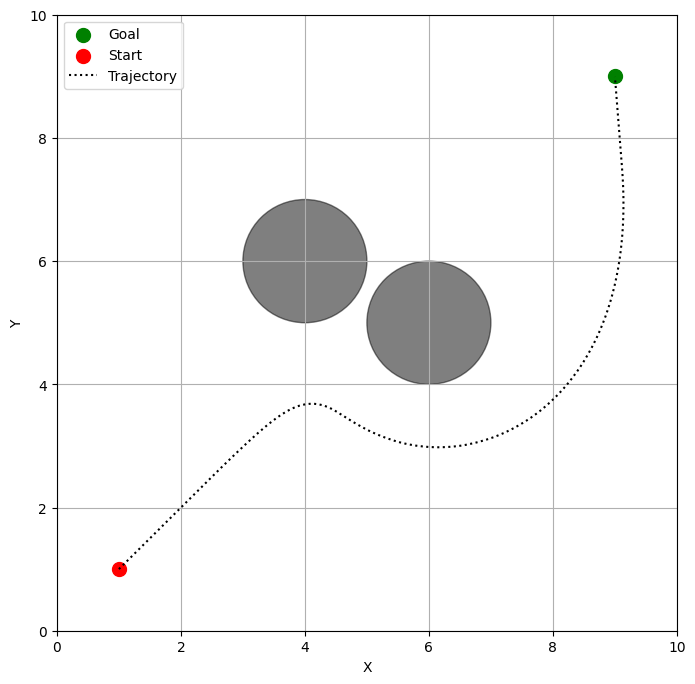

In [178]:
# Parameters for the environment
Goal = torch.tensor([9.0, 9.0], dtype=torch.float32)  # goal position
Start = torch.tensor([1.0, 1.0], dtype=torch.float32)  # start position

Obstacles = torch.tensor([[4.0, 6.0], [6.0, 5.0]], dtype=torch.float32)  # obstacle positions
Obstacle_radius = 1  # radius of the circular obstacles
Threshold = 4 # Threshold (i.e., rho_0), typically larger than Obstacle_radius
Constant_Parameter_K = 1

# Plotting the environment
plt.figure(figsize=(8, 8))
plt.scatter(Goal[0], Goal[1], color="green", label="Goal", s=100)
plt.scatter(Start[0], Start[1], color="red", label="Start", s=100)
for obs in Obstacles.numpy():
    circle = plt.Circle((obs[0], obs[1]), Obstacle_radius, color="black", alpha=0.5)
    plt.gca().add_artist(circle)
    
x_vals = [pos[0].item() for pos in trajectory]
y_vals = [pos[1].item() for pos in trajectory]
plt.plot(x_vals, y_vals, color="black", label="Trajectory", linestyle="dotted")    

# Create a grid environment
grid_size = 10  # size of the grid
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Discuss the results in your report

Experiment with different step size or learning rate for gradient descent, evaluate their performance. Then, analyze and discuss your findings in the report. You do not need to write code for this section—focus on interpreting and explaining the results in your discussion.

In [168]:
# TODO: discuss your results in your report, no code required here.